In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from ripple_detection import Karlsson_ripple_detector, Kay_ripple_detector


# Simulate LFP with Ripple

In [3]:
import scipy.stats

from ripple_detection.simulate import brown, simulate_time

SAMPLING_FREQUENCY = 1500
n_samples = SAMPLING_FREQUENCY * 3
time = simulate_time(n_samples, SAMPLING_FREQUENCY)
brown_noise = brown(time.shape[0])
RIPPLE_FREQUENCY = 200
ripple_signal = np.sin(2 * np.pi * time * RIPPLE_FREQUENCY)
carrier = scipy.stats.norm(loc=1.05, scale=0.100 / 6).pdf(time)
carrier /= carrier.max()


(0.9, 1.2)

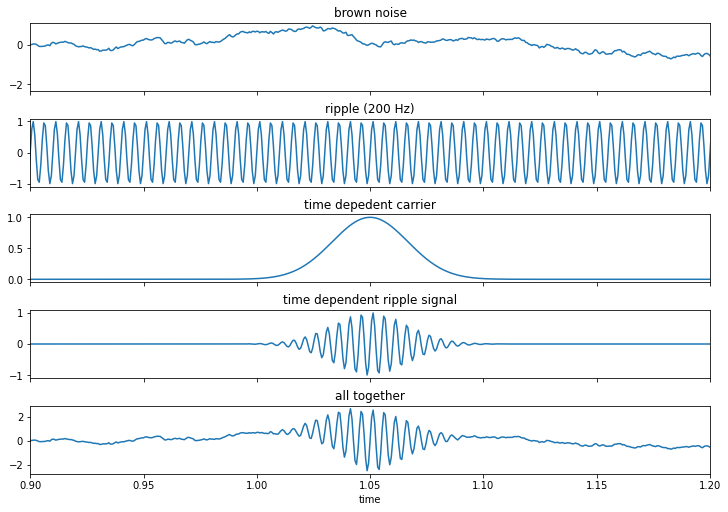

In [4]:
f, ax = plt.subplots(5, 1, sharex=True, figsize=(10, 7), constrained_layout=True)
ax[0].plot(time, brown_noise)
ax[0].set_title("brown noise")
ax[1].plot(time, ripple_signal)
ax[1].set_title("ripple (200 Hz)")
ax[2].plot(time, carrier)
ax[2].set_title("time depedent carrier")
ax[3].plot(time, (ripple_signal * carrier))
ax[3].set_title("time dependent ripple signal")
ax[4].plot(time, 5 / 2 * (ripple_signal * carrier) + brown_noise)
ax[4].set_title("all together")
ax[4].set_xlabel("time")

plt.xlim(0.9, 1.2)


## Test Ripple Detectors
#### Single LFP
Simulate a single LFP with ripples at time 1.1 and time 2.1

This is with brown noise $\frac{1}{f^2}$

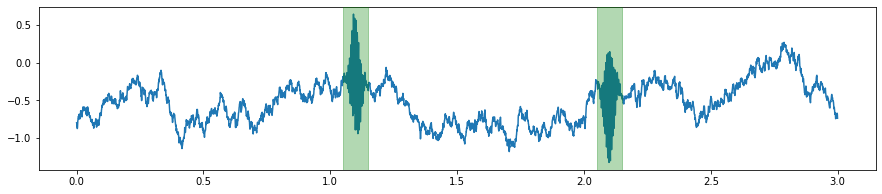

In [5]:
from ripple_detection.simulate import simulate_LFP

true_ripple_midtime = [1.1, 2.1]
RIPPLE_DURATION = 0.100
lfps = simulate_LFP(
    time, true_ripple_midtime, noise_amplitude=1.2, ripple_amplitude=1.5
)[:, np.newaxis]
speed = np.ones_like(time)

fig, ax = plt.subplots(figsize=(15, 3))
plt.plot(time, lfps)


for midtime in true_ripple_midtime:
    plt.axvspan(
        midtime - RIPPLE_DURATION / 2,
        midtime + RIPPLE_DURATION / 2,
        alpha=0.3,
        color="green",
        zorder=1000,
    )


,start_time,end_time,duration,mean_zscore,median_zscore,max_zscore,min_zscore,speed_at_start,speed_at_end,max_speed,min_speed,median_speed,mean_speed
event_number,,,,,,,,,,,,,
1,1.048667,1.141333,0.092667,3.02417,2.558311,6.873906,0.000770,1.0,1.0,1.0,1.0,1.0,1.0
2,2.058667,2.145333,0.086667,3.25739,2.910497,7.030903,0.004139,1.0,1.0,1.0,1.0,1.0,1.0


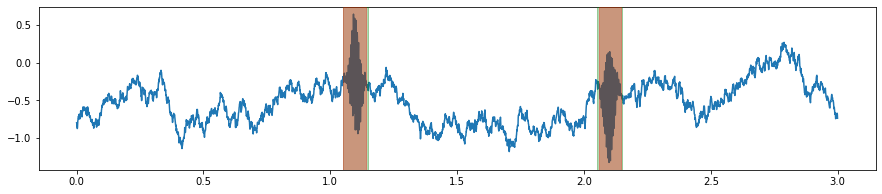

In [6]:
from ripple_detection import filter_ripple_band

filtered_lfps = filter_ripple_band(lfps)
Karlsson_ripple_times = Karlsson_ripple_detector(
    time, filtered_lfps, speed, SAMPLING_FREQUENCY
)

display(Karlsson_ripple_times)

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(time, lfps)

for midtime in true_ripple_midtime:
    ax.axvspan(
        midtime - RIPPLE_DURATION / 2,
        midtime + RIPPLE_DURATION / 2,
        alpha=0.3,
        color="green",
        zorder=9,
    )

for ripple in Karlsson_ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color="red", zorder=10)


,start_time,end_time,duration,mean_zscore,median_zscore,max_zscore,min_zscore,speed_at_start,speed_at_end,max_speed,min_speed,median_speed,mean_speed
event_number,,,,,,,,,,,,,
1,1.050,1.142667,0.092667,3.059377,2.672114,6.783248,0.001780,1.0,1.0,1.0,1.0,1.0,1.0
2,2.058,2.146667,0.088667,3.216931,2.879117,6.942504,0.007878,1.0,1.0,1.0,1.0,1.0,1.0


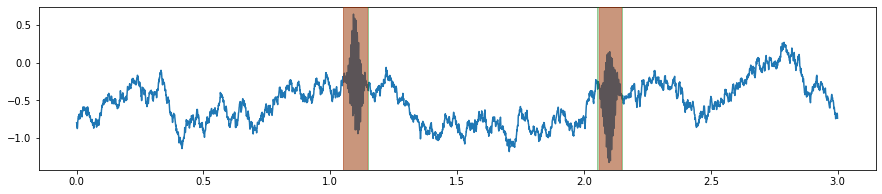

In [7]:
Kay_ripple_times = Kay_ripple_detector(time, filtered_lfps, speed, SAMPLING_FREQUENCY)

display(Kay_ripple_times)

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(time, lfps)


for midtime in true_ripple_midtime:
    ax.axvspan(
        midtime - RIPPLE_DURATION / 2,
        midtime + RIPPLE_DURATION / 2,
        alpha=0.3,
        color="green",
        zorder=9,
    )

for ripple in Kay_ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color="red", zorder=1000)


### Two LFPs

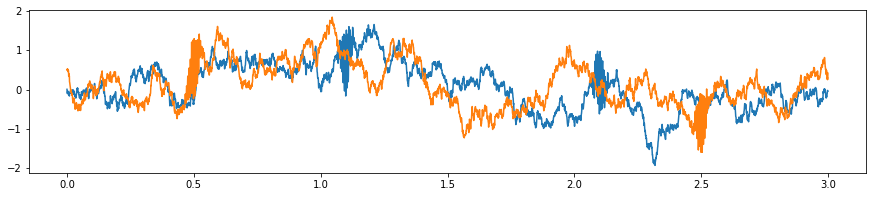

In [8]:
lfps = np.stack(
    (
        simulate_LFP(time, [1.1, 2.1], noise_amplitude=1.2, ripple_amplitude=1.5),
        simulate_LFP(time, [0.5, 2.5], noise_amplitude=1.2, ripple_amplitude=1.5),
    ),
    axis=1,
)

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(time, lfps)
speed = np.ones_like(time)


,start_time,end_time,duration,mean_zscore,median_zscore,max_zscore,min_zscore,speed_at_start,speed_at_end,max_speed,min_speed,median_speed,mean_speed
event_number,,,,,,,,,,,,,
1,0.461333,0.545333,0.084000,1.565126,1.488801,3.418398,-0.157216,1.0,1.0,1.0,1.0,1.0,1.0
2,1.060667,1.140667,0.080000,1.710489,1.620148,3.620305,-0.128927,1.0,1.0,1.0,1.0,1.0,1.0
3,2.060667,2.139333,0.078667,1.640936,1.629828,3.409777,-0.158617,1.0,1.0,1.0,1.0,1.0,1.0
4,2.455333,2.536000,0.080667,1.572712,1.520607,3.463234,-0.107846,1.0,1.0,1.0,1.0,1.0,1.0


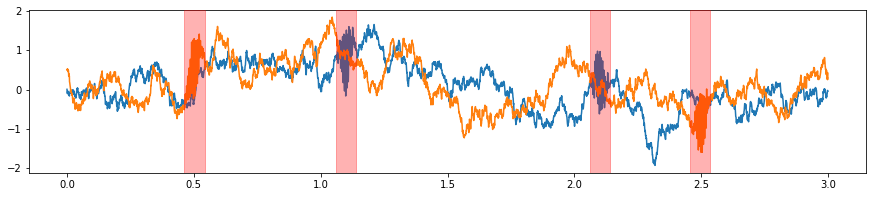

In [9]:
filtered_lfps = filter_ripple_band(lfps)
Karlsson_ripple_times = Karlsson_ripple_detector(
    time, filtered_lfps, speed, SAMPLING_FREQUENCY
)

display(Karlsson_ripple_times)

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(time, lfps)
for ripple in Karlsson_ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color="red", zorder=1000)


,start_time,end_time,duration,mean_zscore,median_zscore,max_zscore,min_zscore,speed_at_start,speed_at_end,max_speed,min_speed,median_speed,mean_speed
event_number,,,,,,,,,,,,,
1,0.464000,0.541333,0.077333,2.451089,2.460202,4.895362,0.022020,1.0,1.0,1.0,1.0,1.0,1.0
2,1.061333,1.136667,0.075333,2.592630,2.444262,5.177944,0.014651,1.0,1.0,1.0,1.0,1.0,1.0
3,2.064000,2.138000,0.074000,2.542882,2.471816,4.984348,0.018953,1.0,1.0,1.0,1.0,1.0,1.0
4,2.460000,2.534000,0.074000,2.461665,2.507483,4.897280,0.006395,1.0,1.0,1.0,1.0,1.0,1.0


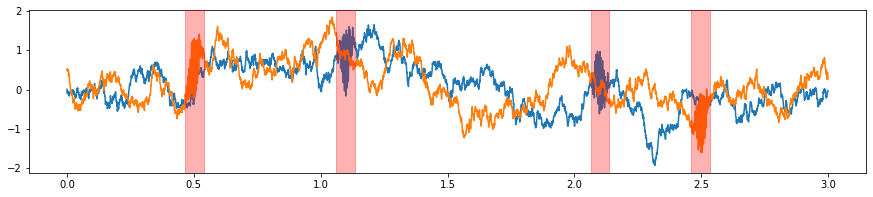

In [10]:
Kay_ripple_times = Kay_ripple_detector(time, filtered_lfps, speed, SAMPLING_FREQUENCY)

display(Kay_ripple_times)

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(time, lfps)
for ripple in Kay_ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color="red", zorder=1000)


## Two LFPs with close ripples

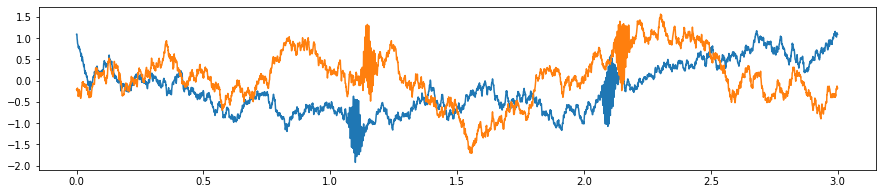

In [11]:
lfps = np.stack(
    (
        simulate_LFP(time, [1.100, 2.100], noise_amplitude=1.2, ripple_amplitude=1.5),
        simulate_LFP(time, [1.150, 2.150], noise_amplitude=1.2, ripple_amplitude=1.5),
    ),
    axis=1,
)

fig, ax = plt.subplots(figsize=(15, 3))
plt.plot(time, lfps)
speed = np.ones_like(time)


,start_time,end_time,duration,mean_zscore,median_zscore,max_zscore,min_zscore,speed_at_start,speed_at_end,max_speed,min_speed,median_speed,mean_speed
event_number,,,,,,,,,,,,,
1,1.064000,1.188667,0.124667,2.098636,2.339824,3.453295,-0.124312,1.0,1.0,1.0,1.0,1.0,1.0
2,2.058667,2.191333,0.132667,2.035339,2.312571,3.471591,-0.137894,1.0,1.0,1.0,1.0,1.0,1.0


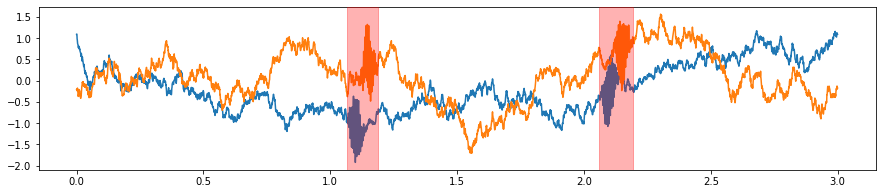

In [12]:
filtered_lfps = filter_ripple_band(lfps)
Karlsson_ripple_times = Karlsson_ripple_detector(
    time, filtered_lfps, speed, SAMPLING_FREQUENCY
)

display(Karlsson_ripple_times)

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(time, lfps)
for ripple in Karlsson_ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color="red", zorder=1000)


,start_time,end_time,duration,mean_zscore,median_zscore,max_zscore,min_zscore,speed_at_start,speed_at_end,max_speed,min_speed,median_speed,mean_speed
event_number,,,,,,,,,,,,,
1,1.064667,1.186000,0.121333,3.006314,3.192796,4.939055,0.002434,1.0,1.0,1.0,1.0,1.0,1.0
2,2.064000,2.188667,0.124667,3.024778,3.209570,4.988067,0.024029,1.0,1.0,1.0,1.0,1.0,1.0


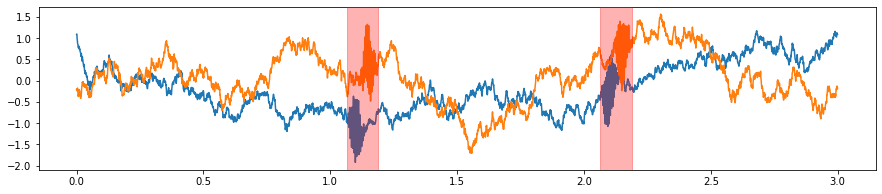

In [13]:
Kay_ripple_times = Kay_ripple_detector(time, filtered_lfps, speed, SAMPLING_FREQUENCY)

display(Kay_ripple_times)

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(time, lfps)
for ripple in Kay_ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color="red", zorder=1000)


## Many LFPs, only two LFPs with ripples

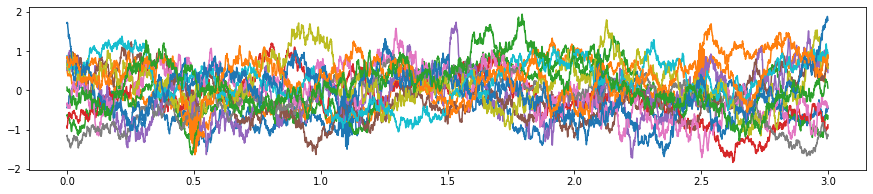

In [14]:
lfps = np.stack(
    (
        simulate_LFP(time, [1.1, 2.1], noise_amplitude=1.2, ripple_amplitude=1.5),
        simulate_LFP(time, [0.5, 2.5], noise_amplitude=1.2, ripple_amplitude=1.5),
        simulate_LFP(time, [], noise_amplitude=1.2, ripple_amplitude=1.5),
        simulate_LFP(time, [], noise_amplitude=1.2, ripple_amplitude=1.5),
        simulate_LFP(time, [], noise_amplitude=1.2, ripple_amplitude=1.5),
        simulate_LFP(time, [], noise_amplitude=1.2, ripple_amplitude=1.5),
        simulate_LFP(time, [], noise_amplitude=1.2, ripple_amplitude=1.5),
        simulate_LFP(time, [], noise_amplitude=1.2, ripple_amplitude=1.5),
        simulate_LFP(time, [], noise_amplitude=1.2, ripple_amplitude=1.5),
        simulate_LFP(time, [], noise_amplitude=1.2, ripple_amplitude=1.5),
        simulate_LFP(time, [], noise_amplitude=1.2, ripple_amplitude=1.5),
        simulate_LFP(time, [], noise_amplitude=1.2, ripple_amplitude=1.5),
        simulate_LFP(time, [], noise_amplitude=1.2, ripple_amplitude=1.5),
    ),
    axis=1,
)
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(time, lfps)
speed = np.ones_like(time)


,start_time,end_time,duration,mean_zscore,median_zscore,max_zscore,min_zscore,speed_at_start,speed_at_end,max_speed,min_speed,median_speed,mean_speed
event_number,,,,,,,,,,,,,
1,0.456667,0.538667,0.082000,0.265810,0.315874,0.586958,-0.145092,1.0,1.0,1.0,1.0,1.0,1.0
2,1.062000,1.142000,0.080000,0.221212,0.178021,1.030257,-0.402231,1.0,1.0,1.0,1.0,1.0,1.0
3,2.060667,2.145333,0.084667,0.133540,0.173598,0.532732,-0.336397,1.0,1.0,1.0,1.0,1.0,1.0
4,2.449333,2.538000,0.088667,0.269890,0.311027,0.632612,-0.168086,1.0,1.0,1.0,1.0,1.0,1.0


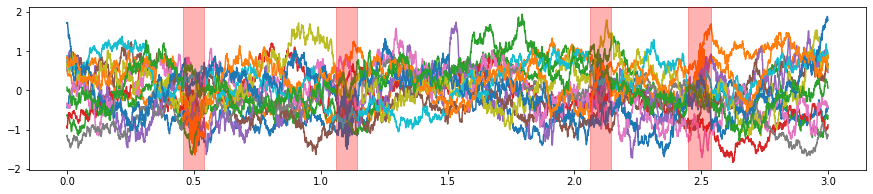

In [15]:
filtered_lfps = filter_ripple_band(lfps)
Karlsson_ripple_times = Karlsson_ripple_detector(
    time, filtered_lfps, speed, SAMPLING_FREQUENCY
)

display(Karlsson_ripple_times)

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(time, lfps)
for ripple in Karlsson_ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color="red", zorder=1000)


,start_time,end_time,duration,mean_zscore,median_zscore,max_zscore,min_zscore,speed_at_start,speed_at_end,max_speed,min_speed,median_speed,mean_speed
event_number,,,,,,,,,,,,,
1,0.461333,0.532667,0.071333,2.447427,2.264958,5.087081,0.017682,1.0,1.0,1.0,1.0,1.0,1.0
2,1.068667,1.134667,0.066000,2.878155,3.043115,5.122262,0.048397,1.0,1.0,1.0,1.0,1.0,1.0
3,2.065333,2.135333,0.070000,2.545452,2.570497,4.920361,0.017889,1.0,1.0,1.0,1.0,1.0,1.0
4,2.466000,2.534000,0.068000,2.682095,2.604071,5.187513,0.018328,1.0,1.0,1.0,1.0,1.0,1.0


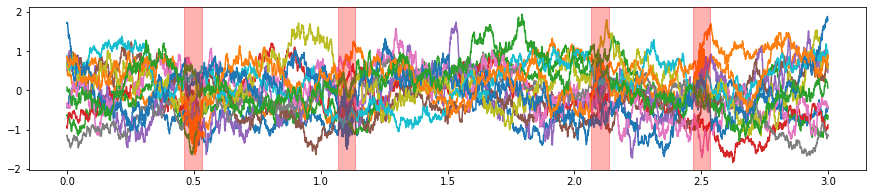

In [16]:
Kay_ripple_times = Kay_ripple_detector(time, filtered_lfps, speed, SAMPLING_FREQUENCY)

display(Kay_ripple_times)

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(time, lfps)
for ripple in Kay_ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color="red", zorder=1000)


## Two LFPs but speed criterion is not met for second ripple

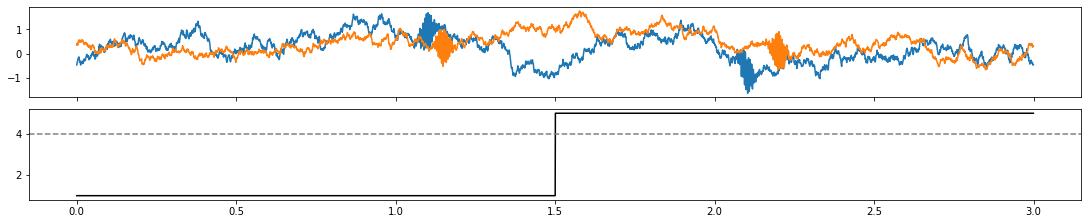

In [17]:
lfps = np.stack(
    (
        simulate_LFP(time, [1.1, 2.1], noise_amplitude=1.2, ripple_amplitude=1.5),
        simulate_LFP(time, [1.15, 2.2], noise_amplitude=1.2, ripple_amplitude=1.5),
    ),
    axis=1,
)


speed = np.ones_like(time)
speed[time > 1.5] = 5

fig, axes = plt.subplots(2, 1, figsize=(15, 3), sharex=True, constrained_layout=True)
axes[0].plot(time, lfps)
axes[1].plot(time, speed, color="black")
axes[1].axhline(4, color="grey", linestyle="--")


,start_time,end_time,duration,mean_zscore,median_zscore,max_zscore,min_zscore,speed_at_start,speed_at_end,max_speed,min_speed,median_speed,mean_speed
event_number,,,,,,,,,,,,,
1,1.060667,1.188,0.127333,2.047288,2.244676,3.437625,-0.07784,1.0,1.0,1.0,1.0,1.0,1.0


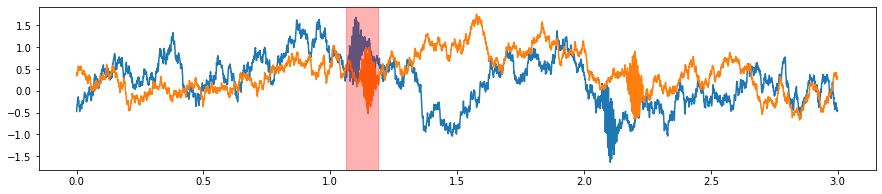

In [18]:
filtered_lfps = filter_ripple_band(lfps)
Karlsson_ripple_times = Karlsson_ripple_detector(
    time, filtered_lfps, speed, SAMPLING_FREQUENCY
)

display(Karlsson_ripple_times)

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(time, lfps)
for ripple in Karlsson_ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color="red", zorder=1000)


,start_time,end_time,duration,mean_zscore,median_zscore,max_zscore,min_zscore,speed_at_start,speed_at_end,max_speed,min_speed,median_speed,mean_speed
event_number,,,,,,,,,,,,,
1,1.064667,1.188,0.123333,2.933565,3.08622,4.989067,0.002836,1.0,1.0,1.0,1.0,1.0,1.0


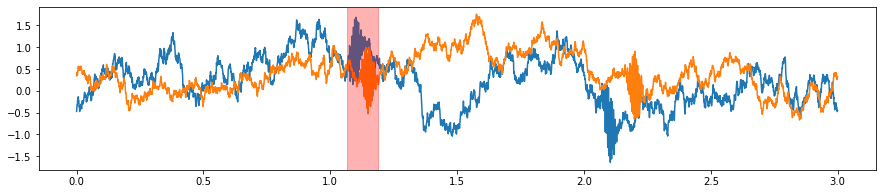

In [19]:
Kay_ripple_times = Kay_ripple_detector(time, filtered_lfps, speed, SAMPLING_FREQUENCY)

display(Kay_ripple_times)

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(time, lfps)
for ripple in Kay_ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color="red", zorder=1000)


## Ripple but duration is too short

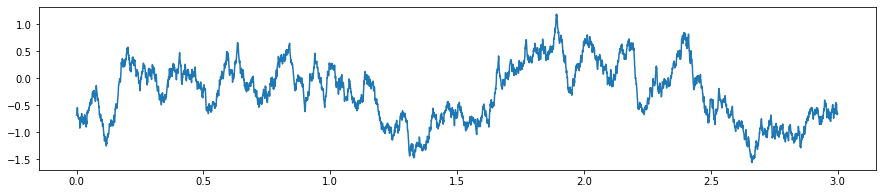

In [20]:
lfps = np.stack(
    (
        simulate_LFP(
            time,
            [1.1, 2.1],
            noise_amplitude=1.2,
            ripple_amplitude=1.5,
            ripple_duration=0.001,
        ),
    ),
    axis=1,
)

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(time, lfps)
speed = np.ones_like(time)


,start_time,end_time,duration,mean_zscore,median_zscore,max_zscore,min_zscore,speed_at_start,speed_at_end,max_speed,min_speed,median_speed,mean_speed
event_number,,,,,,,,,,,,,


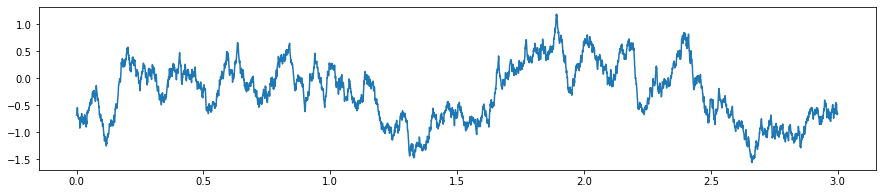

In [21]:
filtered_lfps = filter_ripple_band(lfps)
Karlsson_ripple_times = Karlsson_ripple_detector(
    time, filtered_lfps, speed, SAMPLING_FREQUENCY
)

display(Karlsson_ripple_times)

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(time, lfps)
for ripple in Karlsson_ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color="red", zorder=1000)


,start_time,end_time,duration,mean_zscore,median_zscore,max_zscore,min_zscore,speed_at_start,speed_at_end,max_speed,min_speed,median_speed,mean_speed
event_number,,,,,,,,,,,,,
1,2.959333,2.992667,0.033333,2.051658,2.191025,3.326667,0.038348,1.0,1.0,1.0,1.0,1.0,1.0


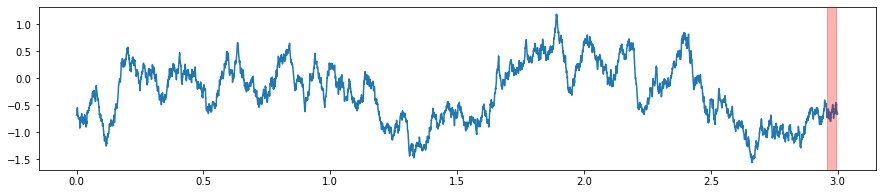

In [22]:
Kay_ripple_times = Kay_ripple_detector(time, filtered_lfps, speed, SAMPLING_FREQUENCY)

display(Kay_ripple_times)

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(time, lfps)
for ripple in Kay_ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color="red", zorder=1000)


### NO ripple

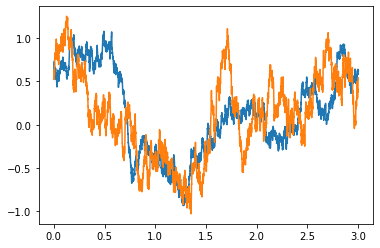

In [23]:
lfps = np.stack(
    (
        simulate_LFP(time, [], noise_amplitude=1.0, ripple_amplitude=1.5),
        simulate_LFP(time, [], noise_amplitude=1.0, ripple_amplitude=1.5),
    ),
    axis=1,
)
plt.plot(time, lfps)
speed = np.ones_like(time)


,start_time,end_time,duration,mean_zscore,median_zscore,max_zscore,min_zscore,speed_at_start,speed_at_end,max_speed,min_speed,median_speed,mean_speed
event_number,,,,,,,,,,,,,


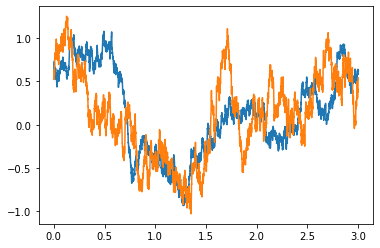

In [24]:
filtered_lfps = filter_ripple_band(lfps)
Karlsson_ripple_times = Karlsson_ripple_detector(
    time, filtered_lfps, speed, SAMPLING_FREQUENCY
)

display(Karlsson_ripple_times)

f, ax = plt.subplots()
ax.plot(time, lfps)
for ripple in Karlsson_ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color="red", zorder=1000)


,start_time,end_time,duration,mean_zscore,median_zscore,max_zscore,min_zscore,speed_at_start,speed_at_end,max_speed,min_speed,median_speed,mean_speed
event_number,,,,,,,,,,,,,
1,1.260,1.338667,0.078667,1.407488,0.868069,3.263487,0.017234,1.0,1.0,1.0,1.0,1.0,1.0
2,2.724,2.800000,0.076000,1.753710,1.722090,4.200008,0.034425,1.0,1.0,1.0,1.0,1.0,1.0


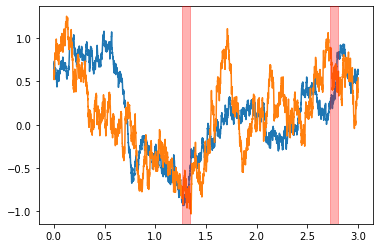

In [25]:
Kay_ripple_times = Kay_ripple_detector(time, filtered_lfps, speed, SAMPLING_FREQUENCY)

display(Kay_ripple_times)

f, ax = plt.subplots()
ax.plot(time, lfps)
for ripple in Kay_ripple_times.itertuples():
    ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color="red", zorder=1000)
